In [1]:
import pandas as pd
df_unemployment = pd.read_csv('Unemployment.csv')
df_disasters = pd.read_csv('US_Natural_Disasters_by_Quarter.csv')
display(df_unemployment.head())
display(df_disasters.head())

,year,quarter,month,state,unemployment_rate
0,2018,Q1,1,AZ,4.9
1,2018,Q1,1,CA,4.4
2,2018,Q1,1,CO,2.9
3,2018,Q1,1,DE,4.1
4,2018,Q1,1,DC,5.9


,Quarter,Disaster,Estimated Damages,States Affected
0,Q4 2018,Hurricane Michael,$25.5 billion,"Florida, Georgia, Alabama, South Carolina, Nor..."
1,Q4 2018,Camp Fire,$16.5 billion,California
2,Q1 2019,Missouri River Flooding,$10.8 billion,"Nebraska, Iowa, Missouri, Kansas, South Dakota"
3,Q2 2019,Arkansas River Floods,$3.0 billion,Arkansas
4,Q3 2020,Hurricane Laura,$19.0 billion,"Louisiana, Texas, Arkansas, Mississippi"


In [2]:
# First, make a copy to avoid modifying the original DataFrame
df_disasters_expanded = df_disasters.copy()

# Drop rows where 'states affected' is missing
df_disasters_expanded = df_disasters_expanded.dropna(subset=['States Affected'])

# Split the 'states affected' column by comma and optional whitespace, then explode
df_disasters_expanded['States Affected'] = df_disasters_expanded['States Affected'].str.split(r',\s*')
df_disasters_expanded = df_disasters_expanded.explode('States Affected')

# Rename the column to 'state' and strip any leading/trailing whitespace
df_disasters_expanded.rename(columns={'States Affected': 'state'}, inplace=True)
df_disasters_expanded['state'] = df_disasters_expanded['state'].str.strip()

# Display the updated DataFrame
df_disasters_expanded.head()


,Quarter,Disaster,Estimated Damages,state
0,Q4 2018,Hurricane Michael,$25.5 billion,Florida
0,Q4 2018,Hurricane Michael,$25.5 billion,Georgia
0,Q4 2018,Hurricane Michael,$25.5 billion,Alabama
0,Q4 2018,Hurricane Michael,$25.5 billion,South Carolina
0,Q4 2018,Hurricane Michael,$25.5 billion,North Carolina


In [3]:
# Dictionary mapping full state names to their two-letter abbreviations
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}

# Map the full state names to abbreviations
df_disasters_expanded['state'] = df_disasters_expanded['state'].map(state_abbrev)

# Drop rows where the state was not recognized (optional)
df_disasters_expanded = df_disasters_expanded.dropna(subset=['state'])

# Display the updated DataFrame
df_disasters_expanded.head()

,Quarter,Disaster,Estimated Damages,state
0,Q4 2018,Hurricane Michael,$25.5 billion,FL
0,Q4 2018,Hurricane Michael,$25.5 billion,GA
0,Q4 2018,Hurricane Michael,$25.5 billion,AL
0,Q4 2018,Hurricane Michael,$25.5 billion,SC
0,Q4 2018,Hurricane Michael,$25.5 billion,NC


In [4]:
# Extract 'Year' and 'Quarter' from the original 'Quarter' column
df_disasters_expanded[['Quarter', 'Year']] = df_disasters_expanded['Quarter'].str.extract(r'(Q\d)\s*(\d{4})')

# Drop rows where 'Year' or 'Quarter' wasn't extracted properly
df_disasters_expanded = df_disasters_expanded.dropna(subset=['Year', 'Quarter'])

# Convert 'Year' to integer
df_disasters_expanded['Year'] = df_disasters_expanded['Year'].astype(int)

# Display the result
df_disasters_expanded.head()


,Quarter,Disaster,Estimated Damages,state,Year
0,Q4,Hurricane Michael,$25.5 billion,FL,2018
0,Q4,Hurricane Michael,$25.5 billion,GA,2018
0,Q4,Hurricane Michael,$25.5 billion,AL,2018
0,Q4,Hurricane Michael,$25.5 billion,SC,2018
0,Q4,Hurricane Michael,$25.5 billion,NC,2018


In [6]:
# Step 1: Add numeric quarter index to both datasets
def to_quarter_index(year, quarter):
    quarter_num = int(quarter[1])  # convert 'Q1' -> 1
    return year * 4 + (quarter_num - 1)

# Apply to disasters
df_disasters_expanded['quarter_index'] = df_disasters_expanded.apply(
    lambda row: to_quarter_index(row['Year'], row['Quarter']), axis=1
)

# Apply to unemployment
df_unemployment['quarter_index'] = df_unemployment.apply(
    lambda row: to_quarter_index(row['year'], row['quarter']), axis=1
)

# Step 2: Loop over each disaster and extract +/- 2 quarters of unemployment data
result_rows = []

for _, disaster in df_disasters_expanded.iterrows():
    state = disaster['state']
    disaster_qi = disaster['quarter_index']
    
    # Filter unemployment data for this state and 2 quarters before/after
    affected_rows = df_unemployment[
        (df_unemployment['state'] == state) &
        (df_unemployment['quarter_index'].between(disaster_qi - 2, disaster_qi + 2))
    ].copy()
    
    # Label the timeframe
    def tag(qi):
        if qi < disaster_qi:
            return 'before'
        elif qi == disaster_qi:
            return 'during'
        else:
            return 'after'
    
    affected_rows['before_or_after'] = affected_rows['quarter_index'].apply(tag)
    affected_rows['disaster'] = disaster['Disaster']
    affected_rows['disaster_quarter'] = f"{disaster['Year']} {disaster['Quarter']}"
    
    result_rows.append(affected_rows)

# Step 3: Combine all rows into final DataFrame
df_disaster_unemployment = pd.concat(result_rows, ignore_index=True)

# Show result
df_disaster_unemployment.head() 

,year,quarter,month,state,unemployment_rate,quarter_index,before_or_after,disaster,disaster_quarter
0,2018,Q2,4,FL,3.8,8073,before,Hurricane Michael,2018 Q4
1,2018,Q2,5,FL,3.7,8073,before,Hurricane Michael,2018 Q4
2,2018,Q2,6,FL,3.6,8073,before,Hurricane Michael,2018 Q4
3,2018,Q3,7,FL,3.6,8074,before,Hurricane Michael,2018 Q4
4,2018,Q3,8,FL,3.5,8074,before,Hurricane Michael,2018 Q4


In [7]:
# Group by 'before_or_after' and calculate the average unemployment rate
trend_summary = df_disaster_unemployment.groupby('before_or_after')['unemployment_rate'].mean().reset_index()

# Rename for clarity
trend_summary.columns = ['Period', 'Average Unemployment Rate']

# Display the result
print(trend_summary)

   Period  Average Unemployment Rate
0   after                   4.461635
1  before                   4.909375
2  during                   4.808333


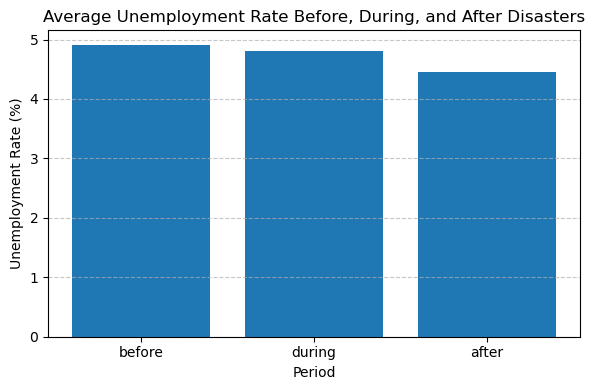

In [8]:
import matplotlib.pyplot as plt

# Sort to ensure logical order
order = ['before', 'during', 'after']
trend_summary['Period'] = pd.Categorical(trend_summary['Period'], categories=order, ordered=True)
trend_summary = trend_summary.sort_values('Period')

# Plot
plt.figure(figsize=(6, 4))
plt.bar(trend_summary['Period'], trend_summary['Average Unemployment Rate'])
plt.title('Average Unemployment Rate Before, During, and After Disasters')
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Period')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import ttest_ind

# Separate unemployment rates by period
before = df_disaster_unemployment[df_disaster_unemployment['before_or_after'] == 'before']['unemployment_rate']
after = df_disaster_unemployment[df_disaster_unemployment['before_or_after'] == 'after']['unemployment_rate']

# Perform Welch’s t-test (independent, unequal variance)
t_stat, p_value = ttest_ind(before, after, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpretation at 90% confidence level
alpha = 0.10
if p_value < alpha:
    print("✅ The difference is statistically significant at the 90% confidence level.")
else:
    print("❌ The difference is NOT statistically significant at the 90% confidence level.")


T-statistic: 1.8407129016728303
P-value: 0.06663543795743469
✅ The difference is statistically significant at the 90% confidence level.


Correlation between unemployment rate and disaster occurrence: 0.03097008598152169
